# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from pandas import DataFrame

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Прочитайте данные из файла

In [2]:
data_path = "ham-spam.csv"

In [3]:
sample = pd.read_csv(data_path, sep=',')

In [4]:
sample[2000:2005]

,target,msg
2000,spam,Subject : family name history discover your fa...
2001,spam,Subject : re : = 20 the virtual girlfriend and...
2002,spam,Subject : home business : $ 10 k / mth : no se...
2003,spam,"Subject : re : your free web site this is a "" ..."
2004,spam,Subject : > > free low rate phone card giveawa...


### Реализуйте все методы в классе NaiveBayes

In [5]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob

        # Количество сообщений, содержащих определенное слово в заданной категории 
        # числитель (list(Counter: word : num_word))
        self.feature_category_counts = []

        # Количество встреч слова во всех сообщениях #total
        self.feature_counts = []

        # Количество всех документов в данной категории 
        # знаменатель
        # Counter(cat : num_msg)
        self.category_doc_counts = []

    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        self.feature_category_counts = []
        self.feature_counts = []
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        self.category_doc_counts = Counter(y_train) 

        for j in range(len(list(Counter(y_train)))):
            self.feature_category_counts.append([])
            for i in range(len(y_train)):
                #print(y_train[i], list(Counter(y_train))[j])
                if (y_train[i] == list(Counter(y_train))[j]):
                    clearText = re.sub(r'[^A-Za-z ]', "", x_train[i])
                    sepText = clearText.split()
                    self.feature_category_counts[j].extend(sepText)
            self.feature_counts.extend(self.feature_category_counts[j])
            self.feature_category_counts[j] = Counter(self.feature_category_counts[j])

        self.feature_counts = Counter(self.feature_counts)
        

        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        if (self.category_priors == None):
            self.category_priors =  []
            for cat in self.get_categories():
                P_up = self.category_doc_counts[cat]
                P_down = sum(list(self.category_doc_counts.values()))
                self.category_priors.append(P_up / P_down)

        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        #Вход функции: list of str
        
        categories = []
        
        for elem in text:
            categories.append(self.get_categories()[np.argmax(self.get_probs(elem))])

        return categories

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        
        return accuracy_score(labels, self.predict(text))

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        # Токенизируем текст, если это необходимо
        probs = []
        for cat in self.get_categories():
            probs.append(self.get_category_prob(cat, text))

        return probs

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятность принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        ind_cat = self.get_categories().index(cat)
        clearText = re.sub(r'[^A-Za-z ]', "", text)
        sepText = clearText.split()
        
        # P(cat)
        log_prob = math.log(self.category_priors[ind_cat], math.e)
            
        for elem in sepText:
            log_prob += math.log(self.get_weighted_feature_prob(cat, elem), math.e)
     
        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        #total количество слова везде
        total = self.feature_counts[feature]
        
        #числитель - количество сообщений, где есть данное слово в данной категории
        ind_cat = self.get_categories().index(cat)
        cond_prob_up = self.feature_category_counts[ind_cat][feature]
        
        #знаменатель - количество сообщений в данной категории
        cond_prob_down = self.category_doc_counts[cat]
        prob = (self.weight * self.supposed_prob + total * (cond_prob_up / cond_prob_down)) / (self.weight + total)
        return prob

    def get_categories(self):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat_list : list of str
        """
        return list(self.category_doc_counts)
pass


In [6]:
NB1 = NaiveBayes()

In [7]:
X_train, X_test = list(sample['msg'])[290:2892], sample['msg'][1800:]
y_train, y_test = list(sample['target'])[290:2892], sample['target'][1800:]

In [8]:
NB1.fit(X_train,y_train)
print(NB1.score(X_test,y_test))

0.929551692589


### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [9]:
# Предобработка данных для классификатора nltk, если требуется
def preprocessing(X,y):
    X = [Counter(x) for x in X]
    return zip(X, y)

In [10]:
# Используйте процедуру KFold для проверки качества классификаторов
acc_NB = []
acc_nltk_NB = []
pred_nltk_NB = []
X = sample['msg']
y = sample['target']

myNB = NaiveBayes()
nltk_NB = NaiveBayesClassifier
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

10

In [11]:
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    myNB.fit(list(X_train), list(y_train))
    acc_NB.append(myNB.score(X_test, y_test))
    
    nltk_NB = nltk_NB.train(preprocessing(X_train, y_train))    
    pred_nltk_NB = nltk_NB.classify_many([Counter(x) for x in X_test])
    acc_nltk_NB.append(accuracy_score(y_test, pred_nltk_NB))        

In [12]:
print("my accuracy: ", np.mean(acc_NB))
print("nltk accuracy: ", np.mean(acc_nltk_NB))

my accuracy:  0.921195561389
nltk accuracy:  0.745585252357



### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

In [13]:
import seaborn as sns

In [14]:
d = DataFrame({'acc': acc_NB})
d2 = DataFrame({'acc': acc_nltk_NB})

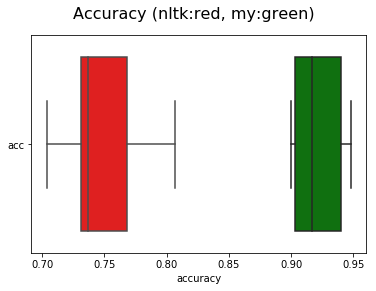

In [15]:
sns.boxplot(data=d, orient="h", color='green')
sns.boxplot(data=d2, orient="h", color='red')
plt.suptitle("Accuracy (nltk:red, my:green)", size=16)
plt.xlabel("accuracy")
plt.show()